# GloVe

Do this:
1. Compare them based on syntactic accuracy and semantic accuracy, similar to how is done in https://nlp.stanford.edu/pubs/glove.pdf (see Table 2) - NO NEED to try 1000 or 300 embed size.....I just want you to learn how to do experiment.....
2. Try to find a correlation with just ONE similarity dataset (which humans judge how similar is two words.....)

Point criteria:
0:  Not done
1: ok
2: with comments / explanation / figures just like how Chaky explain thing.....

Some suggestions for the assignment report:
1. Write a brief conclusion on your findings at the end of the report.
2. Clear long outputs in the notebook before submission.

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import spacy
import nltk

## 1. Load Data

In [2]:
#using real corpus from nltk
from nltk.corpus import brown
nltk.download('brown')
corpus = nltk.corpus.brown.sents(categories=['reviews'])

[nltk_data] Downloading package brown to C:\Users\Sirikit
[nltk_data]     Joshi\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [3]:
#let's check the size of the corpus
print(len(corpus))

1751


In [4]:
#1. Tokenize
corpus_tokenized = [[word.lower() for word in sent] for sent in corpus]
print(corpus_tokenized[:5])

[['it', 'is', 'not', 'news', 'that', 'nathan', 'milstein', 'is', 'a', 'wizard', 'of', 'the', 'violin', '.'], ['certainly', 'not', 'in', 'orchestra', 'hall', 'where', 'he', 'has', 'played', 'countless', 'recitals', ',', 'and', 'where', 'thursday', 'night', 'he', 'celebrated', 'his', '20th', 'season', 'with', 'the', 'chicago', 'symphony', 'orchestra', ',', 'playing', 'the', 'brahms', 'concerto', 'with', 'his', 'own', 'slashing', ',', 'demon-ridden', 'cadenza', 'melting', 'into', 'the', 'high', ',', 'pale', ',', 'pure', 'and', 'lovely', 'song', 'with', 'which', 'a', 'violinist', 'unlocks', 'the', 'heart', 'of', 'the', 'music', ',', 'or', 'forever', 'finds', 'it', 'closed', '.'], ['there', 'was', 'about', 'that', 'song', 'something', 'incandescent', ',', 'for', 'this', 'brahms', 'was', 'milstein', 'at', 'white', 'heat', '.'], ['not', 'the', 'noblest', 'performance', 'we', 'have', 'heard', 'him', 'play', ',', 'or', 'the', 'most', 'spacious', ',', 'or', 'even', 'the', 'most', 'eloquent', '.'

In [5]:
#2. numericalize

#2.1 get all the unique words
#we want to flatten this (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))  #vocabs is a term defining all unique words your system know
print(vocabs[0:5])

['my', 'bruhn', 'closeup', 'allegory', 'recounting']


In [6]:
#2.2 assign id to all these vocabs
word2index = {v: idx+1 for idx, v in enumerate(vocabs)}

#add <UNK>, which is a very normal token exists in the world
vocabs.append('<UNK>') #chaky, can it be ##UNK, or UNKKKKKK, or anything

word2index['<UNK>'] = 0 
# word2index

In [7]:
#create index2word dictionary
index2word = {v:k for k, v in word2index.items()}
# index2word

## 2.  Creating co-occurrence matrix

In [8]:
#Build Co-occurence Matrix
from collections import Counter

X_i = Counter(flatten(corpus))
# print(X_i)

In [9]:
#creating random_batch_skipgram
def random_batch_skipgram(corpus, window_size = 1):
    skip_grams = []
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = sent[i]
            context = []
            for j in range(window_size):
                if i - (j + 1) >= 0:  ## Checking  if out of range from left of list
                    context.append(sent[i - (j + 1)])
                if i + (j + 1) < len(sent): 
                    context.append(sent[i + (j + 1)])
            for w in context:
                skip_grams.append((target,w))
    return skip_grams

In [10]:
skip_grams = []
cbows = []
window_size = 2
#for each corpus
for sent in corpus_tokenized:
    for i in range(1,len(sent)-window_size): #start from 2 to second last
        context_word = []
        # print(sent[i])
        center_word = sent[i]
        for j in range(window_size):
            outside_word = [sent[i-j-1],sent[i+j+1]] #window_size adjustable
            #here we want to create (banana, apple), (banana, fruit) append to some list
            for o in outside_word:
                context_word.append(o)
                skip_grams.append((center_word,o))
            cbows.append((context_word,center_word))

In [11]:
#finding co-occurance in skip_grams with window size = 2
X_ik_skipgram = Counter(random_batch_skipgram(corpus, window_size = 2))

# print(X_ik_skipgram)

In [12]:
#Weight function in order to scale down frequent words

def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [13]:
#now apply this weighting to all possible pairs
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocabs, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        cooc = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = cooc + 1 # + 1 for stability issue
        X_ik[(bigram[1], bigram[0])] = cooc + 1   #count also for the opposite
    else:
        pass

    #apply the weighting function using this co-occurrence matrix thingy   
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

    #removed printing to avoid crashing

## 3. Preparing Train Data

In [14]:
#preparing train data

import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):

    #loop through skipgram, and change it id because when sending model, it must number 
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    #randomly pick 'batch_size' indexes
    number_of_choices = len(skip_grams_id)
    random_index = np.random.choice(number_of_choices, batch_size, replace=False) #no repeating indexes among  these random indexes
    
    random_inputs = [] #xi, wi (in batches)
    random_labels = [] #xj, wj (in batches)
    random_coocs  = [] #xij (in batches)
    random_weighting = [] #f(xij) (in batches)
    #for each of the sample in these indexes
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]]) #same reason why I put bracket here....
        random_labels.append([skip_grams_id[i][1]])

        #get coocs
        #first check whether it exists.....
        pair = skip_grams[i] #e.g., ['banana','fruit']
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1 #label smoothing

        random_coocs.append([math.log(cooc)]) #1. why log, #2 why bracket -> size ==> (,1) #my neural network excepts (,1)
        
        #for weighting
        weighting = weighting_dic[pair] #why not user try... maybe it does not exist
        random_weighting.append(weighting)

    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weighting)

In [15]:
batch_size = 2
input, target, cooc, weightin = random_batch(batch_size, corpus_tokenized, skip_grams, X_ik, weighting_dic)
input, target, cooc, weightin

(array([[2854],
        [1633]]),
 array([[ 126],
        [1801]]),
 array([[2.7080502 ],
        [0.69314718]]),
 array([0.24102853, 0.05318296]))

## 4. Glove Model

In [16]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

In [17]:
voc_size   = len(vocabs)
batch_size = 2 
emb_size   = 2 
model      = GloVe(voc_size, emb_size)

optimizer  = optim.Adam(model.parameters(), lr=0.0001)

In [20]:
import time
num_epochs = 4000
start = time.time()
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input, target, cooc, weightin = random_batch(batch_size, corpus_tokenized, skip_grams, X_ik, weighting_dic)
    input_batch    = torch.LongTensor(input)
    target_batch   = torch.LongTensor(target)
    cooc_batch     = torch.FloatTensor(cooc)
    weightin_batch = torch.FloatTensor(weightin)
    
    
    # print(input_batch.shape, label_batch.shape, cooc_batch.shape, weightin_batch)
    
    #loss = model
    loss = model(input_batch, target_batch, cooc_batch, weightin_batch)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        end = time.time()
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {(end-start)}")


Epoch 1000 | Loss: 0.263171 | Time: 40.35958695411682
Epoch 2000 | Loss: 2.676057 | Time: 82.35004210472107
Epoch 3000 | Loss: 0.508378 | Time: 124.43235373497009
Epoch 4000 | Loss: 3.206538 | Time: 164.54973196983337


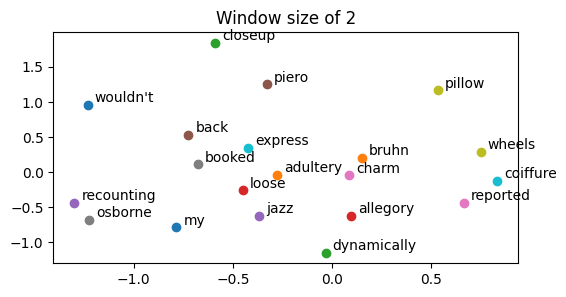

In [21]:
# Function to get embedding
def get_embed(word, current_model=model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (current_model.embedding_v(word)+current_model.embedding_u(word))/2
    return np.array(embed[0].detach().numpy())

plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.title('Window size of 2')
plt.show()


In [22]:
import pickle

torch.save(model.state_dict(), "Glove_Model.pth")

In [23]:
from scipy import spatial

def cosine_similarity(word1, word2):
    '''
        cosine_similarity function accepts the embeddings of two words and returns the 
        the degree of similarity between them using scipy.
    '''
    cos_sim = 1 - spatial.distance.cosine(word1, word2)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

In [24]:
#getting cosine similarity
adultery = get_embed('adultery')
loose = get_embed('loose')
pillow = get_embed('pillow')

print(f"adultery vs loose: ", cosine_similarity(adultery, loose))
print(f"loose vs pillow: ", cosine_similarity(loose, pillow))

adultery vs loose:  0.9278067350387573
loose vs pillow:  -0.8149043321609497


## 5. Testing

### 5.1 Loading test data

In [26]:
import spacy 
import pandas as pd

nlp = spacy.load('en_core_web_sm')
file =  open('../SIRI_code_along/Data/questions-words.txt', mode='r')
question_words = []
for content in file:
  question_words.append(content)

print(question_words[0:10])

[': capital-common-countries\n', 'Athens Greece Baghdad Iraq\n', 'Athens Greece Bangkok Thailand\n', 'Athens Greece Beijing China\n', 'Athens Greece Berlin Germany\n', 'Athens Greece Bern Switzerland\n', 'Athens Greece Cairo Egypt\n', 'Athens Greece Canberra Australia\n', 'Athens Greece Hanoi Vietnam\n', 'Athens Greece Havana Cuba\n']


In [27]:
class Skipgram(nn.Module):
    '''
        Skipgram implementation 
        class that accepts the parameter vocabulary
        size and embedding size
    '''
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        center_word_embed  = self.embedding_center_word(center_word)     
        outside_word_embed = self.embedding_outside_word(outside_word)  
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)    
        
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        
        top_term_exp = torch.exp(top_term) 
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        
        return loss_fn

In [28]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, emb_size) # out embedding
        self.logsigmoid = nn.LogSigmoid()
                    
    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        neg_embeds    = -self.embedding_u(negative_words) # [batch_size, num_neg, emb_size]
        
        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        negative_score = neg_embeds.bmm(center_embeds.transpose(1, 2))
        #[batch_size, k, emb_size] @ [batch_size, emb_size, 1] = [batch_size, k, 1]
        
        loss = self.logsigmoid(positive_score) + torch.sum(self.logsigmoid(negative_score), 1)
                
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds

In [29]:
class CBOW(nn.Module):
    ''' Continuous Bag of words implementation 
        class that accepts the parameter vocabulary
        size and embedding size'''
    def __init__(self, voc_size, emb_size):
        super(CBOW, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        center_word_embed  = self.embedding_center_word(center_word)     
        outside_word_embed = self.embedding_outside_word(outside_word)  
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)    
        
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        
        top_term_exp = torch.exp(top_term) 
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        
        return loss_fn

In [31]:
# Separate header name and index
separator = [(idx, sent) for idx, sent in enumerate(question_words) if sent[0] == ':']
separator

[(0, ': capital-common-countries\n'),
 (507, ': capital-world\n'),
 (5032, ': currency\n'),
 (5899, ': city-in-state\n'),
 (8367, ': family\n'),
 (8874, ': gram1-adjective-to-adverb\n'),
 (9867, ': gram2-opposite\n'),
 (10680, ': gram3-comparative\n'),
 (12013, ': gram4-superlative\n'),
 (13136, ': gram5-present-participle\n'),
 (14193, ': gram6-nationality-adjective\n'),
 (15793, ': gram7-past-tense\n'),
 (17354, ': gram8-plural\n'),
 (18687, ': gram9-plural-verbs\n')]

In [33]:
adjective_to_adverb = question_words[8875:9867]
comparative         = question_words[10681:12013]
nationality         = question_words[14194:15793]

In [39]:
print(adjective_to_adverb[0:5], "\n")
print(comparative[0:5], "\n")
print(nationality[0:5], "\n")

['amazing amazingly apparent apparently\n', 'amazing amazingly calm calmly\n', 'amazing amazingly cheerful cheerfully\n', 'amazing amazingly complete completely\n', 'amazing amazingly efficient efficiently\n'] 

['bad worse big bigger\n', 'bad worse bright brighter\n', 'bad worse cheap cheaper\n', 'bad worse cold colder\n', 'bad worse cool cooler\n'] 

['Albania Albanian Argentina Argentinean\n', 'Albania Albanian Australia Australian\n', 'Albania Albanian Austria Austrian\n', 'Albania Albanian Belarus Belorussian\n', 'Albania Albanian Brazil Brazilian\n'] 



In [40]:
test_text = adjective_to_adverb + comparative + nationality

In [41]:
test_adj_to_adv = [sentence.split(" ") for sentence in adjective_to_adverb]
test_comparative = [sentence.split(" ") for sentence in comparative]
test_nation = [sentence.split(" ") for sentence in nationality]
test_set = [sentence.split(" ") for sentence in test_text]

In [42]:
print(test_set[0:5])

[['amazing', 'amazingly', 'apparent', 'apparently\n'], ['amazing', 'amazingly', 'calm', 'calmly\n'], ['amazing', 'amazingly', 'cheerful', 'cheerfully\n'], ['amazing', 'amazingly', 'complete', 'completely\n'], ['amazing', 'amazingly', 'efficient', 'efficiently\n']]


### 5.2 Flatten and get unique words

In [43]:
flatten = lambda l: [item for sublist in l for item in sublist]
test_vocab = list(set(flatten(test_set)))
test_vocab[0:10]

['quiet',
 'stronger\n',
 'Dutch',
 'Netherlands',
 'Swedish',
 'faster\n',
 'seriously\n',
 'tighter',
 'furiously\n',
 'louder\n']

In [44]:
test_word2index = dict()
test_word2index.update({"":  0})
for idx, v in enumerate(test_vocab):
        test_word2index.update({v:  idx + 1})

test_vocab.append('')

test_index2word = {v:k for k, v in test_word2index.items()}

## 6. Semantic Testing

In [74]:
def find_analogy(a,b,c,current_model, vocabs=vocabs):
    emb_a, emb_b, emb_c = get_embed(a, current_model), get_embed(b, current_model), get_embed(c, current_model)
    vector = emb_b - emb_a + emb_c
    similarity = -1 
    
    for vocab in vocabs:
        if vocab not in [a,b,c]: #ignore input words itself
            current_sim = cosine_similarity(vector,get_embed(vocab, current_model))
            if current_sim > similarity:
                similarity = current_sim #update better one
                d = (vocab, similarity)
    return d

In [46]:
find_analogy('amazing','amazingly','apparent')

('dora', 1)

In [69]:
def check_accuracy(y, yhat):
    if y == yhat:
        return True
    else:
        return False

def test_accuracy_batch(data, current_model):
    counter = 0
    for sent in data:
        label = sent[-1]
        a, b, c = sent[:-1]
        yhat = find_analogy(a, b, c, current_model)[0] # It's return in tuple form, so we need to slice to get word
        if check_accuracy(label, yhat) == True:
            counter = counter + 1
    
    return counter

In [49]:
embedding_size = 2

In [52]:
#load skipgram_model
skipgram_model = Skipgram(voc_size, embedding_size)
torch.save(skipgram_model.state_dict(), "SkipgramsModel.pth")
skipgram_model.load_state_dict(torch.load('SkipgramsModel.pth'))
skipgram_model.eval()

Skipgram(
  (embedding_center_word): Embedding(8070, 2)
  (embedding_outside_word): Embedding(8070, 2)
)

In [53]:
#load negative skipgram model
neg_skipgram_model = SkipgramNegSampling(voc_size, embedding_size)
torch.save(neg_skipgram_model.state_dict(), "Neg_SkipgramsModel.pth")
neg_skipgram_model.load_state_dict(torch.load('Neg_SkipgramsModel.pth'))
neg_skipgram_model.eval()

SkipgramNegSampling(
  (embedding_v): Embedding(8070, 2)
  (embedding_u): Embedding(8070, 2)
  (logsigmoid): LogSigmoid()
)

In [54]:
#load cbow model
cbow_model = CBOW(voc_size, embedding_size)
torch.save(cbow_model.state_dict(), "Cbow_Model.pth")
cbow_model.load_state_dict(torch.load('Cbow_Model.pth'))
cbow_model.eval()

CBOW(
  (embedding_center_word): Embedding(8070, 2)
  (embedding_outside_word): Embedding(8070, 2)
)

#### 6.1 For Glove

In [60]:
import random

current_model = GloVe(voc_size, embedding_size)
current_model.load_state_dict(torch.load('Glove_Model.pth'))
current_model.eval()

test_list = [test_adj_to_adv, test_comparative, test_nation]
test_list_name = ['test_adj_to_adv','test_comparative', 'test_nation']

for idx, current_test in enumerate(test_list):
   sample_list = random.choices(current_test, k=100)
   print(f'Current_test = {test_list_name[idx]}')
   accuracy = test_accuracy_batch(sample_list, current_model)
   print(accuracy)

Current_test = test_adj_to_adv
0
Current_test = test_comparative
0
Current_test = test_nation
0


#### 6.2 For Skipgram Model

In [61]:
embedding_size = 2

current_model = Skipgram(voc_size, embedding_size)
current_model.load_state_dict(torch.load('SkipgramsModel.pth'))
current_model.eval()

test_list = [test_adj_to_adv, test_comparative, test_nation]
test_list_name = ['test_adj_to_adv','test_comparative', 'test_nation']

for idx, current_test in enumerate(test_list):
   sample_list = random.choices(current_test, k=100)
   print(f'Current_test = {test_list_name[idx]}')
   accuracy = test_accuracy_batch(sample_list, current_model)
   print(accuracy)

Current_test = test_adj_to_adv
0
Current_test = test_comparative
0
Current_test = test_nation
0


#### 6.3 For CBOW Model

In [ ]:
embedding_size = 2

current_model = CBOW(voc_size, embedding_size)
current_model.load_state_dict(torch.load('Cbow_Model.pth'))
current_model.eval()

test_list = [test_adj_to_adv, test_comparative, test_nation]
test_list_name = ['test_adj_to_adv','test_comparative', 'test_nation']

for idx, current_test in enumerate(test_list):
   sample_list = random.choices(current_test, k=100)
   print(f'Current_test = {test_list_name[idx]}')
   accuracy = test_accuracy_batch(sample_list, current_model)
   print(accuracy)

#### 6.4 For Skipgram with Negative Sampling

In [64]:
#Override get embed for negative sampling due to embedding name change
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

In [72]:
def get_embed(word, current_model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (current_model.embedding_v(word)+ current_model.embedding_u(word))/2
    return np.array(embed[0].detach().numpy())

In [75]:
embedding_size = 2

current_model = SkipgramNegSampling(voc_size, embedding_size)
current_model.load_state_dict(torch.load('Neg_SkipgramsModel.pth'))
current_model.eval()

test_list = [test_adj_to_adv, test_comparative, test_nation]
test_list_name = ['test_adj_to_adv','test_comparative', 'test_nation']

for idx, current_test in enumerate(test_list):
   sample_list = random.choices(current_test, k=100)
   print(f'Current_test = {test_list_name[idx]}')
   accuracy = test_accuracy_batch(sample_list, current_model)
   print(accuracy)

Current_test = test_adj_to_adv
0
Current_test = test_comparative
0
Current_test = test_nation
0


## 7. Syntactic Testing

In [76]:
import pandas as pd
path = '../SIRI_code_along/Data/wordsim353_sim_rel/wordsim_similarity_goldstandard.txt'
df = pd.read_table(path, header=None)
df.head()

,0,1,2
0,tiger,cat,7.35
1,tiger,tiger,10.00
2,plane,car,5.77
3,train,car,6.31
4,television,radio,6.77


In [77]:
sytactic_test_set = df.iloc[:20]
sytactic_test_set.head()

,0,1,2
0,tiger,cat,7.35
1,tiger,tiger,10.00
2,plane,car,5.77
3,train,car,6.31
4,television,radio,6.77


In [78]:
x1 = sytactic_test_set[0]
x2 = sytactic_test_set[1]
label = sytactic_test_set[2]

#### 7.1 Glove

In [80]:
from scipy import stats
embedding_size=2
model = GloVe(voc_size, embedding_size)
model.load_state_dict(torch.load('Glove_Model.pth'))
model.eval()

test_list = [test_adj_to_adv, test_comparative, test_nation]
test_list_name = ['test_adj_to_adv', 'test_comparative', 'test_nation']

results = []
for idx in range(20): # We test with only fix 10 samples
    emb_x1 = get_embed(x1[idx], model)
    emb_x2 = get_embed(x2[idx], model)
    yhat = stats.spearmanr(emb_x1, emb_x2)
    yhat = yhat[0]
    results.append(yhat)


#### 7.2 Skipgram Model

In [93]:
def get_embed(word, current_model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (current_model.embedding_center_word(word)+current_model.embedding_outside_word (word))/2
    return np.array(embed[0].detach().numpy())

In [83]:
model = skipgram_model

test_list = [test_adj_to_adv, test_comparative, test_nation]
test_list_name = ['test_adj_to_adv', 'test_comparative', 'test_nation']

results = []
for idx in range(20):
    emb_x1 = get_embed(x1[idx], model)
    emb_x2 = get_embed(x2[idx], model)
    yhat = stats.spearmanr(emb_x1, emb_x2)
    yhat = yhat[0]
    results.append(yhat)

#### 7.3 CBOW Model

In [86]:
model = cbow_model

test_list = [test_adj_to_adv, test_comparative, test_nation]
test_list_name = ['test_adj_to_adv', 'test_comparative', 'test_nation']

results = []
for idx in range(20): 
    emb_x1 = get_embed(x1[idx], model)
    emb_x2 = get_embed(x2[idx], model)
    yhat = stats.spearmanr(emb_x1, emb_x2)
    yhat = yhat[0]
    results.append(yhat)

#### 7.4 Skipgram with Negative Sampling

In [100]:
def get_embed(word, current_model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (current_model.embedding_v(word)+current_model.embedding_u(word))/2
    return np.array(embed[0].detach().numpy())

In [101]:
model = neg_skipgram_model

test_list = [test_adj_to_adv, test_comparative, test_nation]
test_list_name = ['test_adj_to_adv', 'test_comparative', 'test_nation']

results = []
for idx in range(20): 
    emb_x1 = get_embed(x1[idx], model)
    emb_x2 = get_embed(x2[idx], model)
    yhat = stats.spearmanr(emb_x1, emb_x2)
    yhat = yhat[0]
    results.append(yhat)

**Conclusion**

All the results come out to 0. This could be because the training dataset was very small. 
